In [1]:
import os
import sys

import math
import time
import datetime
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import CosineAnnealingLR
from don import DeepONet
from scipy.interpolate import interp1d
from torchinfo import summary

# from YourDataset import YourDataset  # Import your custom dataset here
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

import pickle

scaler = GradScaler()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


/tmp/ipykernel_2902918/219706660.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [2]:
# Define your custom loss function here
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, y_pred, y_true, Par, Lambda=None):
        # Implement your custom loss calculation here
        if Lambda is not None:
            residue = torch.absolute(y_true - y_pred)
            Lambda = Par['gamma']*Lambda + Par['eta']*residue/torch.max(residue)
            loss = torch.mean(torch.square(Lambda*residue)) 
        
        else:
            loss = torch.mean(torch.square(y_true - y_pred)) 

        return loss, Lambda

def preprocess(X_func, X_loc, y, Par):
    X_func = (X_func - Par['X_func_shift'])/Par['X_func_scale']
    X_loc  = (X_loc - Par['X_loc_shift'])/Par['X_loc_scale']
    y      = (y - Par['out_shift'])/(Par['out_scale'])
    print('X_func: ', X_func.shape)
    print('X_loc : ', X_loc.shape)
    print('y     : ', y.shape)

    return X_func, X_loc, y

    
def data_prep(dataset, m, npoints_output):
    p = dataset['del_p']
    t = dataset['t']
    r = dataset['R']

    P = interp1d(t, p, kind='cubic')
    R = interp1d(t, r, kind='cubic')

    t_min = 0
    t_max = 5 * 10**-4

    X_func = P(np.linspace(t_min, t_max, m)) #[1500, m] 
    X_loc  = np.linspace(t_min, t_max, npoints_output)[:, None] #[npoints_output,1]
    y      = R(np.ravel(X_loc)) #[1500, npoints_output] 

    return X_func, X_loc, y


In [3]:
# Load your data into NumPy arrays (x_train, t_train, y_train, x_val, t_val, y_val, x_test, t_test, y_test)
#########################

debug = False

dataset = np.load('../data/0.1/res_1000.npz')

m = 200
npoints_output = 500

X_func, X_loc, y = data_prep(dataset, m, npoints_output) 

idx1 = int(0.8*X_func.shape[0])
idx2 = int(0.9*X_func.shape[0])

X_func_train = X_func[:idx1]
X_func_val   = X_func[idx1:idx2]
X_func_test  = X_func[idx2:]

X_loc_train = X_loc
X_loc_val   = X_loc 
X_loc_test  = X_loc

y_train = y[:idx1]
y_val   = y[idx1:idx2]
y_test  = y[idx2:]

Par = {
       'bn_res'        : X_func_train.shape[1],
       'tn_res'        : X_loc_train.shape[1],
       'ld'            : 100,   
       'X_func_shift'  : np.mean(X_func_train),
       'X_func_scale'  : np.std(X_func_train),
       'X_loc_shift'   : np.min(X_loc_train),
       'X_loc_scale'   : np.max(X_loc_train)-np.min(X_loc_train),
       'out_shift'     : np.mean(y_train),
       'out_scale'     : np.std(y_train),
       'eta'           : 0.1,
       'gamma'         : 0.99
       }

Par['Lambda_max'] = Par['eta']/(1 - Par['gamma'])


if debug:
    Par['num_epochs']  = 5
else:
    Par['num_epochs']  = 10000

print('\nTrain Dataset')
X_func_train, X_loc_train, y_train = preprocess(X_func_train, X_loc_train, y_train, Par)
Lambda = np.ones((y_train.shape[0], y_train.shape[1]), dtype=np.float32)*Par['Lambda_max']/2.0
print("Lambda: ", Lambda.shape)

print('\nValidation Dataset')
X_func_val, X_loc_val, y_val = preprocess(X_func_val, X_loc_val, y_val, Par)
print('\nTest Dataset')
X_func_test, X_loc_test, y_test = preprocess(X_func_test, X_loc_test, y_test, Par)

print('Par:\n', Par)

with open('Par.pkl', 'wb') as f:
    pickle.dump(Par, f)

# sys.exit()
#########################

# Create custom datasets
X_func_train_tensor = torch.tensor(X_func_train, dtype=torch.float32)
X_loc_train_tensor = torch.tensor(X_loc_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
Lambda_tensor = torch.tensor(Lambda, dtype=torch.float32)

X_func_val_tensor = torch.tensor(X_func_val, dtype=torch.float32)
X_loc_val_tensor = torch.tensor(X_loc_val, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val,   dtype=torch.float32)

X_func_test_tensor = torch.tensor(X_func_test, dtype=torch.float32)
X_loc_test_tensor = torch.tensor(X_loc_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test,  dtype=torch.float32)

# Define data loaders
train_batch_size = 50
val_batch_size   = 50
test_batch_size  = 50


Train Dataset
X_func:  (1200, 200)
X_loc :  (500, 1)
y     :  (1200, 500)
Lambda:  (1200, 500)

Validation Dataset
X_func:  (150, 200)
X_loc :  (500, 1)
y     :  (150, 500)

Test Dataset
X_func:  (150, 200)
X_loc :  (500, 1)
y     :  (150, 500)
Par:
 {'bn_res': 200, 'tn_res': 1, 'ld': 100, 'X_func_shift': np.float64(-1485.538476351167), 'X_func_scale': np.float64(340.1185777695776), 'X_loc_shift': np.float64(0.0), 'X_loc_scale': np.float64(0.0005), 'out_shift': np.float64(1.0744879013817246e-05), 'out_scale': np.float64(1.9361471092413482e-07), 'eta': 0.1, 'gamma': 0.99, 'Lambda_max': 9.999999999999991, 'num_epochs': 10000}


# Loading the model

In [4]:
# Initialize your Unet2D model
model = DeepONet(Par).to(device).to(torch.float32)
print(summary(model, input_size=((1,)+X_func_train.shape[1:], X_loc_train.shape)  ))

print('Loading model ...')
path_model = 'models/best_model.pt'
model.load_state_dict(torch.load(path_model))

# Define loss function and optimizer
criterion = CustomLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

Layer (type:depth-idx)                   Output Shape              Param #
DeepONet                                 [1, 500]                  --
├─Sequential: 1-1                        [1, 100]                  --
│    └─Linear: 2-1                       [1, 100]                  20,100
│    └─GELU: 2-2                         [1, 100]                  --
│    └─Linear: 2-3                       [1, 100]                  10,100
│    └─GELU: 2-4                         [1, 100]                  --
│    └─Linear: 2-5                       [1, 100]                  10,100
│    └─GELU: 2-6                         [1, 100]                  --
│    └─Linear: 2-7                       [1, 100]                  10,100
│    └─GELU: 2-8                         [1, 100]                  --
│    └─Linear: 2-9                       [1, 100]                  10,100
├─Sequential: 1-2                        [500, 100]                --
│    └─Linear: 2-10                      [500, 100]              

# Sanity Check

In [5]:
# Validation
model.eval()
val_loss = 0.0
with torch.no_grad():
    for start in range(0, X_func_val.shape[0]-1, val_batch_size):
        end = start + val_batch_size
        x = X_func_val_tensor[start:end]
        y_true = y_val_tensor[start:end]  
        with autocast():
            y_pred = model(x.to(device), X_loc_val_tensor.to(device))
            loss, _ = criterion(y_pred, y_true.to(device), Par)
            loss = loss.item()
        val_loss += loss
val_loss /= int(y_val.shape[0]/val_batch_size)
print("Validation Loss: ", val_loss)

Validation Loss:  0.005479417586078246


/tmp/ipykernel_2902918/2611251470.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


In [6]:
y_true_ls = []
y_pred_ls = []

# Testing loop
model.eval()
test_loss = 0.0
with torch.no_grad():
    for start in range(0, X_func_test.shape[0]-1, test_batch_size):
        end = start + test_batch_size
        x = X_func_test_tensor[start:end]
        y_true = y_test_tensor[start:end]  
        with autocast():
            y_pred = model(x.to(device), X_loc_test_tensor.to(device))
            loss, _ = criterion(y_pred, y_true.to(device), Par)
            loss = loss.item()
        y_true_ls.append(y_true)
        y_pred_ls.append(y_pred)
        test_loss += loss 
test_loss /= int(y_test.shape[0]/test_batch_size)
print(f'Test Loss: {test_loss:.4e}')

# # Testing loop
# model.eval()
# test_loss = 0.0
# with torch.no_grad():
#     for x, y_true in test_loader:
#         with autocast():
#             y_pred = model(x.to(device), X_loc_test_tensor.to(device))
#             loss = criterion(y_pred, y_true.to(device), Par).item() 
#         y_true_ls.append(y_true)
#         y_pred_ls.append(y_pred)
#         test_loss += loss 
# test_loss /= len(test_loader)
# print(f'Test Loss: {test_loss:.4e}')

Y_TRUE = torch.cat(y_true_ls, axis=0)
Y_PRED = torch.cat(y_pred_ls, axis=0)

print('true: ', Y_TRUE.shape)
print('pred: ', Y_PRED.shape)

Test Loss: 5.3285e-03
true:  torch.Size([150, 500])
pred:  torch.Size([150, 500])


/tmp/ipykernel_2902918/270682473.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


# Visualization

In [7]:
import matplotlib.pyplot as plt

In [8]:
Y_TRUE = Y_TRUE.detach().cpu().numpy()
Y_PRED = Y_PRED.detach().cpu().numpy()

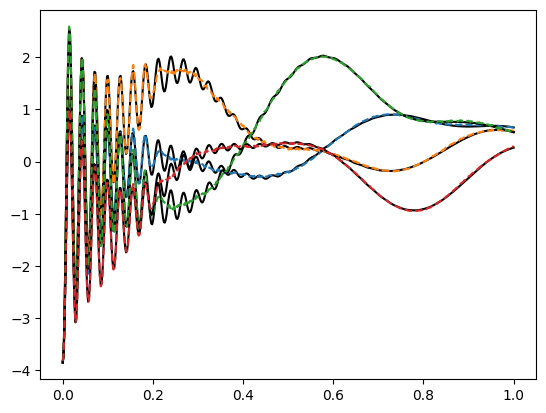

In [9]:
idx = 1

time = X_loc_test[:,0]

plt.plot(time, Y_TRUE[idx],'k')
plt.plot(time, Y_PRED[idx],'--')
plt.plot(time, Y_TRUE[idx+1],'k')
plt.plot(time, Y_PRED[idx+1],'--')
plt.plot(time, Y_TRUE[idx+2],'k')
plt.plot(time, Y_PRED[idx+2],'--')
plt.plot(time, Y_TRUE[idx+3],'k')
plt.plot(time, Y_PRED[idx+3],'--')
plt.show()

In [10]:
np.save("Y_TRUE.npy", Y_TRUE)
np.save("Y_PRED.npy", Y_PRED)
np.save("time.npy", time)